### Q2 

In [81]:
import tool

import scipy, random
import pandas as pd
import numpy as np
from collections import defaultdict

%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, IntSlider

import warnings
warnings.filterwarnings('ignore')

In [82]:
"""
Data import
"""
asset_index = pd.read_csv("data/aidx_eod_prices.csv")

# data sorting/longer than 800 days
grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 800}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)

In [83]:
"""
Parameters
"""

BACKTEST_DAY = 30 # lookback period (not used)
TARGET_RETURN = 0.0 # target return
RISK_FREE_RATE = 0.02 # risk-free rate

NUM_ITERATION = 5 # test amounts
NUM_LIMIT = (5,10) # assets amount limitation range
CORR_LIMIT = 0.5 # assets' correlation limiation

REBALANCE_DAYS = [90, 150, 210, 270] # rebalancing days test
MODEL_TYPES = ['RP', 'RB', 'RB-H', 'RB-G'] # test models
MODEL_TYPES = ['RP', 'RB']

In [84]:
"""
Model rebalancing function
"""

def rebalance(asset_index, rebalance_day, weight_constraints, model_type):
    predicts = []
    actuals = []
    realities = []
    
    for i in range(rebalance_day, len(asset_index), rebalance_day):
        
        if i+rebalance_day >= len(asset_index):
            break
        
        historical_data = asset_index[i-rebalance_day:i]
        future_data = asset_index[i:i+rebalance_day]
        
        predict, actual = tool.evaluate(historical_data, future_data, weight_constraints, model_type, TARGET_RETURN, RISK_FREE_RATE)
        predicts.append(predict)
        actuals.append(actual)
        
        # equally weighed
        reality = tool.check([1 / len(asset_index.columns) for _ in range(len(asset_index.columns))], future_data, RISK_FREE_RATE)
        realities.append(reality)
    
    return predicts, actuals, realities

In [85]:
"""
Asset sampling
"""

def sample(num_limit, asset_dfs, corr_limit):
    index_list = random.sample(list(asset_dfs.keys()), num_limit)
    
    def is_non_related(index_list):
        for i in range(0, len(index_list)):
            for j in range(i+1, len(index_list)):
                i_df = asset_dfs[index_list[i]]
                j_df = asset_dfs[index_list[j]]
                min_length = min(len(i_df['PCHG']), len(j_df['PCHG']))
                corr, _ = scipy.stats.spearmanr(i_df['PCHG'].iloc[:min_length], j_df['PCHG'].iloc[:min_length])
                if corr > corr_limit:
                    return False
        return True
    
    while is_non_related(index_list) == False:
        index_list = random.sample(list(asset_dfs.keys()), num_limit)
    
    return index_list

# sample(20, asset_dfs, 0.3)

In [86]:
"""
Different Models with the same assets (randomly generated) and different rebalancing days
"""

def asset_rebalance(asset, num_limit, model_types, rebalancing_days, asset_dfs, corr_limit):
    
    asset_index = asset.copy()
    
    # randomly select assets
    actual_num_limit = np.random.randint(*num_limit)
    index_list = sample(actual_num_limit, asset_dfs, corr_limit)
    asset_index['TRADE_DT'] = pd.to_datetime(asset_index['TRADE_DT'], format='%Y%m%d')
    asset_index.sort_values(by='TRADE_DT', inplace=True)
    asset_index.set_index('TRADE_DT', inplace=True)
    asset_index = asset_index.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[index_list].dropna()
    
    # weight constraints
    n = len(index_list)
    index_min_weight = [0 for _ in range(n)]
    index_max_weight = [1 for _ in range(n)]
    weight_constraints = list(zip(index_min_weight, index_max_weight))
    
    # start iteration
    results = {}
    for model_type in model_types:
        for rebalance_day in rebalancing_days:
            _, actuals, realities = rebalance(asset_index, rebalance_day, weight_constraints, model_type)
            results[(model_type, rebalance_day)] = list(zip(*actuals))
            results[('EW', rebalance_day)] = list(zip(*realities))
    
    return results, index_list

# results, index_list = asset_rebalance(asset_index, (10,11), MODEL_TYPES, [180, 210], asset_dfs, CORR_LIMIT)
# results = dict(sorted(results.items(), key=lambda item: item[0][1]))
# print(index_list)
# print(results)

In [87]:
"""
Calculate the average for one assets combination with each (model, rebalance_day)
"""

def calculate_averages(data, index_list, exclude_model='EW'):
    grouped_data = defaultdict(dict)

    # Group data by the second key of the tuple
    for (model, period), values in data.items():
        grouped_data[period][model] = values

    results = {}
    draws = defaultdict(dict)

    # Perform division and calculate averages
    for period, models in grouped_data.items():
        ew_values = models.get(exclude_model)
        if ew_values is None:
            continue  # Skip if 'EW' data is not present

        for model, values in models.items():
            if model != exclude_model:
                modified_values = []
                for index, (value, ew_value) in enumerate(zip(values, ew_values)):
                    if index == 0:  # For the first set, use subtraction
                        result = [v - ew for v, ew in zip(value, ew_value)]
                    else:  # For the other sets, use division
                        result = [v / ew if ew != 0 else 0 for v, ew in zip(value, ew_value)]
                    modified_values.append(result)
                    
                averages = [sum(value) / len(value) for value in modified_values]
                results[(model, period)] = averages
                
                for i, value_set in enumerate(modified_values):
                    draws[i][(model, period)] = value_set
    
    # Plotting
    num_plots = len(draws)
    plot_width = max(6, num_plots * 4)  # Adjust width dynamically based on number of plots
    fig, axes = plt.subplots(1, num_plots, figsize=(plot_width, 3))
    titles = ['Return', 'Volatility', 'Sharpe Ratio']
    
    # If there's only one plot, make axes iterable
    if num_plots == 1:
        axes = [axes]
    
    lines = []
    labels = []

    # Plotting
    for i, (ax, title) in enumerate(zip(axes, titles)):
        for (model, period), value_set in draws[i].items():
            line, = ax.plot(value_set, label=f'{model}, {period}')
            if i == 0:  # Add legend entries only once
                lines.append(line)
                labels.append(f'{model}, {period}')
        ax.set_title(f'{title}')
    
    fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=16)
    
    print(index_list)
    
    plt.tight_layout()
    plt.show()

    return results

# t = calculate_averages(results, index_list)
# print(t)

['h30545.CSI', 'CES212.CSI', 'h30012.CSI', '921405.CSI', 'CESYLV.CNI', '931661CNY01.CSI']


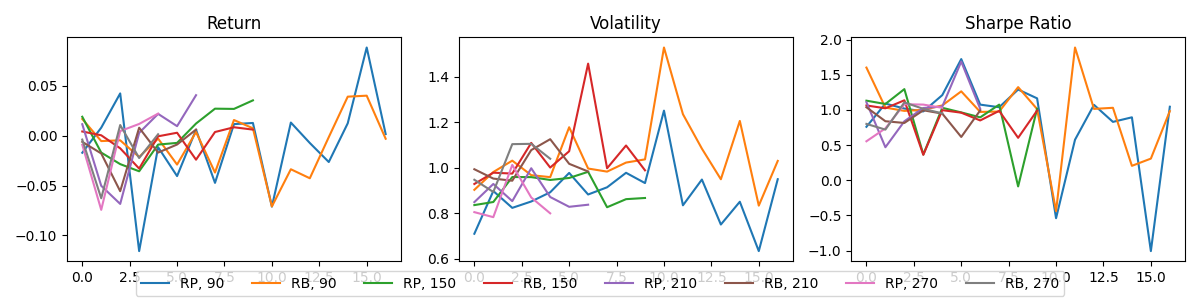

['931867.CSI', '931581.CSI', 'h20795.CSI', '931670CNY01.CSI', '931090.CSI', '931347.CSI', '483025.CNI', '987012.CNI']


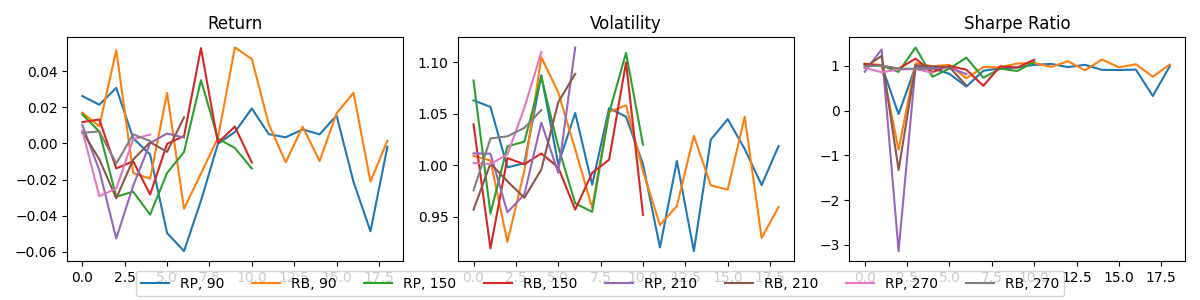

['L01151.CSI', 'h20468.CSI', '980036.CNI', 'h20970.CSI', 'h30487.CSI', '483005.CNI', 'h00048.SH', '921273.CSI']


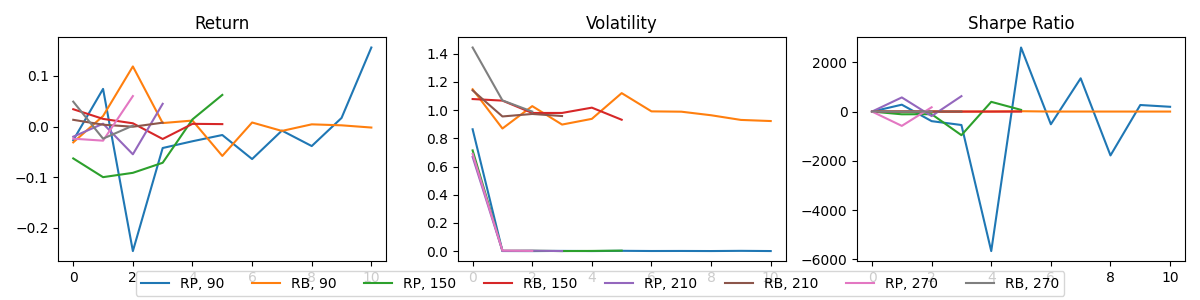

['h11154.CSI', '970028.CNI', 'h20717.CSI', '930754.CSI', '899302.CSI']


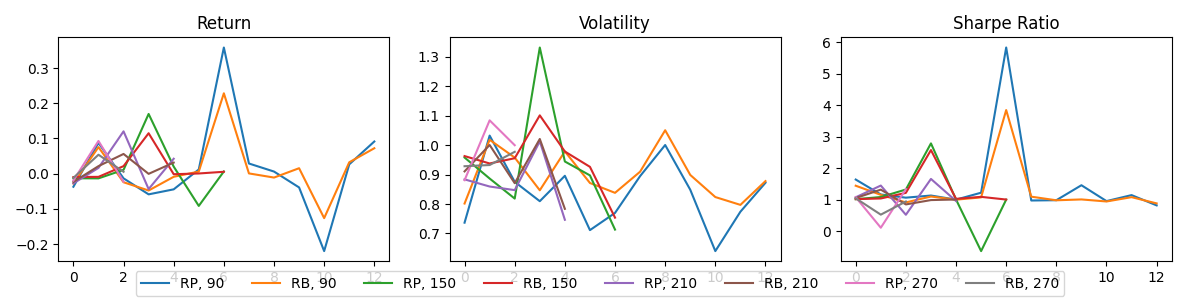

['L11231.CSI', '931119.CSI', '399352.SZ', 'h21085.CSI', 'CES005.CSI', '930998.CSI']


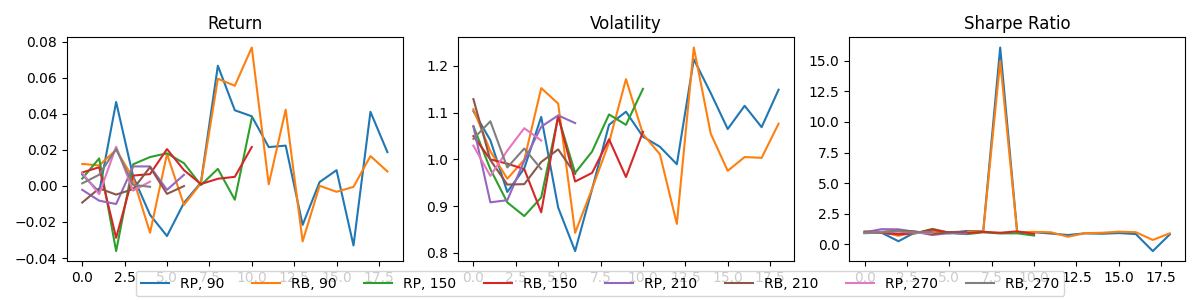

[{('RP', 90): [-0.00832390734267891, 0.8866171622522174, 0.8375507223641252], ('RB', 90): [-0.007652855683577209, 1.0538909195268014, 0.9553957350038284], ('RP', 150): [0.002269303355683369, 0.9039058938313117, 0.8782063089437997], ('RB', 150): [-0.0045018555036842114, 1.060031048845318, 0.8983944886431321], ('RP', 210): [-0.00466180672833139, 0.8805615765892004, 1.0290791315360854], ('RB', 210): [-0.013097976598990103, 1.012817275567656, 0.8928296257729288], ('RP', 270): [-0.009036919984853207, 0.853571170273332, 0.8966917658035742], ('RB', 270): [-0.015434594625566728, 1.017347874849159, 0.9199896039409545]}, {('RP', 90): [-0.003946344851002956, 1.0140409175447422, 0.8531039061358476], ('RB', 90): [0.007653067270966239, 1.0004807523053576, 0.8956148982239761], ('RP', 150): [-0.0065887088524434695, 1.0251387065234754, 0.9876925429794958], ('RB', 150): [0.0026408105245513927, 0.9983071144005872, 0.9625619882722752], ('RP', 210): [-0.010216139306126411, 1.0137584871334224, 0.40459020422

In [88]:
"""
Iteration start
"""

final_results = []
for i in range(0, NUM_ITERATION):
    results, index_list = asset_rebalance(asset_index, NUM_LIMIT, MODEL_TYPES, REBALANCE_DAYS, asset_dfs, CORR_LIMIT)
    results = dict(sorted(results.items(), key=lambda item: item[0][1]))
    results = calculate_averages(results, index_list)
    final_results.append(results)

print(final_results)

In [89]:
"""
Output (for each optimization)
"""
def aggregate_results(dicts):
    aggregated_results = {}

    # Initialize aggregated_results with empty lists for each key
    for key in dicts[0].keys():
        aggregated_results[key] = []

    # Iterate over each dictionary
    for d in dicts:
        print(d)
        for key, values in d.items():
            # Assuming all dictionaries have the same structure
            for i, value in enumerate(values):
                if len(aggregated_results[key]) <= i:
                    aggregated_results[key].append([])
                aggregated_results[key][i].append(value)

    # Convert lists of values to tuples
    for key in aggregated_results:
        aggregated_results[key] = [tuple(lst) for lst in aggregated_results[key]]

    return aggregated_results

aggregated_results = aggregate_results(final_results)
print(aggregated_results)

{('RP', 90): [-0.00832390734267891, 0.8866171622522174, 0.8375507223641252], ('RB', 90): [-0.007652855683577209, 1.0538909195268014, 0.9553957350038284], ('RP', 150): [0.002269303355683369, 0.9039058938313117, 0.8782063089437997], ('RB', 150): [-0.0045018555036842114, 1.060031048845318, 0.8983944886431321], ('RP', 210): [-0.00466180672833139, 0.8805615765892004, 1.0290791315360854], ('RB', 210): [-0.013097976598990103, 1.012817275567656, 0.8928296257729288], ('RP', 270): [-0.009036919984853207, 0.853571170273332, 0.8966917658035742], ('RB', 270): [-0.015434594625566728, 1.017347874849159, 0.9199896039409545]}
{('RP', 90): [-0.003946344851002956, 1.0140409175447422, 0.8531039061358476], ('RB', 90): [0.007653067270966239, 1.0004807523053576, 0.8956148982239761], ('RP', 150): [-0.0065887088524434695, 1.0251387065234754, 0.9876925429794958], ('RB', 150): [0.0026408105245513927, 0.9983071144005872, 0.9625619882722752], ('RP', 210): [-0.010216139306126411, 1.0137584871334224, 0.4045902042258

In [90]:
"""
Visualisation (for each optimization)
"""

def asset_display(data, normalise=True, i=0):
    line_styles = ['-', '--', ':']
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

    def normalize_data(lst):
        return (lst - np.mean(lst)) / np.std(lst)

    line_style = line_styles[i]

    fig, ax = plt.subplots(figsize=(10, 6))
    lines = []

    for (key, lists), color in zip(data.items(), colors):
        if i < len(lists):
            lst = lists[i]
            l = normalize_data(lst) if normalise else lst
            l = np.array(lst)
            # l = l[~np.isnan(l)]
            line, = ax.plot(l, line_style, color=color, label=f'{key}')
            lines.append(line)
    
    if i == 0:
        ax.axhline(y=0, color='red', linestyle=':')
    elif i == 1:
        ax.axhline(y=1, color='red', linestyle=':')
        
    plt.subplots_adjust(right=0.7)
    leg = ax.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    
    lined = {}
    for legline, origline in zip(leg.get_lines(), lines):
        legline.set_picker(5)
        lined[legline] = origline
        
    for legline, line in zip(leg.get_lines(), lines):
        legline.set_alpha(0.2)
        line.set_visible(False)

    avg_text_objects = {}
    
    def on_pick(event):
        legline = event.artist
        origline = lined[legline]
        visible = not origline.get_visible()
        origline.set_visible(visible)
        
        if visible:
            if origline not in avg_text_objects:
                display_position = (0.05, 0.95 - 0.05 * len(avg_text_objects))
                avg_value = np.nanmean(origline.get_ydata())
                avg_text_objects[origline] = ax.text(display_position[0], display_position[1], 
                                                     f'Avg {legline.get_label()}: {avg_value:.4f}', 
                                                     transform=ax.transAxes, color=origline.get_color(),
                                                     fontsize=9, verticalalignment='top')
            else:
                avg_text_objects[origline].set_visible(True)
        else:
            if origline in avg_text_objects:
                avg_text_objects[origline].set_visible(False)
                del avg_text_objects[origline]

        legline.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()

    fig.canvas.mpl_connect('pick_event', on_pick)

    titles = {0 : 'Return', 1 : 'Volatility', 2 : 'Sharpe Ratio'}
    ax.set_title(titles.get(i, 'Q2 Line Plots'))
    ax.set_xlabel('Test Index')
    ax.set_ylabel('Value')

    plt.show()


interact(asset_display,
         data=fixed(aggregated_results),
         normalise=False,
         i=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(Checkbox(value=False, description='normalise'), IntSlider(value=0, description='i', max=…

<function __main__.asset_display(data, normalise=True, i=0)>

|     | Return   |          |          |  | Volatility |          |          |     |
| --- | -------- | -------- | -------- |--| ---------- | -------- | -------- | --- |
|     | RB       | RB-H     | RB-G     |  | RB         | RB-H     | RB-G     |     |
| 90  | 0.0119   | 0.0018   | 0.0026   |  | 0.9936     | 0.9728   | 0.9738   | 90  |
| 120 | 0.0099   | 0.002    | 0.0033   |  | 0.9938     | 0.9733   | 0.9749   | 120 |
| 150 | 0.0093   | 0.002    | 0.0023   |  | 0.9903     | 0.9698   | 0.9743   | 150 |
| 180 | 0.0063   | 0.0012   | 0.0009   |  | 0.9996     | 0.9727   | 0.9685   | 180 |
| 210 | 0.0076   | 0.0032   | 0.0051   |  | 0.9921     | 0.9709   | 0.9747   | 210 |
| 240 | 0.0054   | 0.0018   | 0.0028   |  | 1.0019     | 0.9709   | 0.9756   | 240 |
| 270 | 0.0045   | 0.0014   | 0.0023   |  | 1.0103     | 0.9776   | 0.9837   | 270 |
| 300 | 0.0036   | 0.0011   | 0.0002   |  | 1.0031     | 0.9761   | 0.9916   | 300 |
| avg | 0.007313 | 0.001813 | 0.002438 |  | 0.998088   | 0.973013 | 0.977138 | avg |
|     |          |          |          |  |            |          |          |     |
| 90  | 0.0121   | 0.0023   | 0.0023   |  | 1.0095     | 0.9877   | 0.9911   | 90  |
| 120 | 0.0082   | 0.0017   | 0.0034   |  | 1.0108     | 0.9885   | 0.9895   | 120 |
| 150 | 0.0079   | 0.0017   | 0.0018   |  | 1.0032     | 0.9867   | 0.9883   | 150 |
| 180 | 0.0062   | 0.0007   | \-0.0005 |  | 1.015      | 0.989    | 0.9864   | 180 |
| 210 | 0.004    | 0.0018   | 0.0039   |  | 1.0039     | 0.9836   | 0.9871   | 210 |
| 240 | 0.0051   | 0.0013   | 0.0028   |  | 1.0097     | 0.988    | 0.9899   | 240 |
| 270 | 0.0023   | 0.0008   | 0.0004   |  | 1.0232     | 0.9951   | 0.9974   | 270 |
| 300 | 0.0024   | 0.0006   | \-0.0004 |  | 1.0174     | 0.9913   | 1.0059   | 300 |
| avg | 0.006025 | 0.001363 | 0.001713 |  | 1.011588   | 0.988738 | 0.99195  | avg |
|     |          |          |          |  |            |          |          |     |
| 90  | 0.0131   | 0.0032   | 0.0036   |  | 1.0047     | 0.9809   | 0.9832   | 90  |
| 120 | 0.0098   | 0.003    | 0.0051   |  | 1.003      | 0.9795   | 0.9826   | 120 |
| 150 | 0.0085   | 0.003    | 0.0022   |  | 1.0013     | 0.9794   | 0.9814   | 150 |
| 180 | 0.006    | 0.0024   | 0.0012   |  | 1.0081     | 0.9804   | 0.9793   | 180 |
| 210 | 0.0067   | 0.0028   | 0.0047   |  | 1.0028     | 0.9778   | 0.9857   | 210 |
| 240 | 0.0069   | 0.0029   | 0.0034   |  | 1.0116     | 0.9795   | 0.9881   | 240 |
| 270 | 0.0042   | 0.0031   | 0.0026   |  | 1.021      | 0.9847   | 1.0021   | 270 |
| 300 | 0.003    | 0.0024   | 0.0016   |  | 1.0144     | 0.9862   | 0.9955   | 300 |
| avg | 0.007275 | 0.00285  | 0.00305  |  | 1.008363   | 0.98105  | 0.987238 | avg |